In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import tailer
import os
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
rank_perc = [950, 990, 995]
factors = ["BHLHE40", "CEBPB", "CTCF", "E2F4", "EBF1", "ELF1", "ELK1", "ETS1", "FOS", "IRF4", "JunD", "Max", "MEF2A", "MEF2C", "Mxi1", "NFIC", "NFKB", "NFYA", "NFYB", "Nrf1", "NRSF", "PAX5", "PBX3", "POU2F2", "PU1", "RFX5", "RUNX3", "SP1", "SRF", "STAT1", "STAT3", "TCF3", "USF1", "USF2", "YY1", "ZBTB33", "ZEB1", "Znf143"]

factordata = {}
DIR="/storage/pandaman/project/singletons/AgentBind/"
for f in factors:
    # load data
    fdata = pd.read_csv(os.path.join(DIR, f, "scores.tab"), sep="\t", skiprows=1,
                            names=["chrom","start","raw.score","snr.score","rank","core"])
    fdata = fdata[~np.isnan(fdata["raw.score"])]
    fdata = fdata[~np.isnan(fdata["snr.score"])]
    fdata["factor"] = f
    factordata[f] = fdata
    print (f)

BHLHE40
CEBPB
CTCF
E2F4
EBF1
ELF1
ELK1
ETS1
FOS
IRF4
JunD
Max
MEF2A
MEF2C
Mxi1
NFIC
NFKB
NFYA
NFYB
Nrf1
NRSF
PAX5
PBX3
POU2F2
PU1
RFX5
RUNX3
SP1
SRF
STAT1
STAT3
TCF3
USF1
USF2
YY1
ZBTB33
ZEB1
Znf143


In [3]:
gwas = pd.read_csv("/storage/pandaman/project/GWAS/wbc_N172435_narrow_form.tsv.gz", sep="\t")
gwas["CHR"] = gwas["CHR"].apply(lambda x: "chr"+str(x))
gwas["BP"] = gwas["BP"].apply(lambda x: x-1)
gwas = gwas.rename(columns={"CHR": "chrom", "BP": "start"})

In [4]:
gwd = {}
for f in factors:
    fd = factordata[f]
    fd["chrom"] = fd["chrom"].apply(str)
    merged_df = pd.merge(fd, gwas, on=["chrom","start"])
    merged_df = merged_df[((merged_df["REF"]).str.len() == 1) & ((merged_df["ALT"]).str.len() == 1)]
    merged_df = merged_df.sort_values("rank", ascending=False)
    merged_df = merged_df.drop_duplicates(subset=["chrom", "start"], keep='first')
    gwd[f] = merged_df

In [5]:
bins = [0, 0.00025, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5]

In [6]:
gwd["SP1"].head()

,chrom,start,raw.score,snr.score,rank,core,factor,VARIANT,ID_dbSNP49,REF,ALT,ALT_MINOR,DIRECTION,EFFECT,SE,P,MLOG10P,ALT_FREQ,MA_FREQ
196967,chr10,101491889,0.000210,20.097974,1000.0,0,SP1,10:101491890_C_T,rs574143521,C,T,True,+,0.033076,0.083342,0.6915,0.160233,0.0006,0.0006
198055,chr11,117857065,0.000798,35.639502,1000.0,0,SP1,11:117857066_G_T,rs765806292,G,T,True,+,0.045105,0.080841,0.5769,0.238917,0.0006,0.0006
231818,chr19,17862273,0.000668,22.938656,1000.0,0,SP1,19:17862274_C_A,rs571520837,C,A,True,-,-0.096391,0.148451,0.5161,0.287234,0.0004,0.0004
99145,chr19,51925350,0.000089,43.004951,1000.0,0,SP1,19:51925351_C_A,rs60538328,C,A,True,+,0.004334,0.004167,0.2982,0.525443,0.2683,0.2683
58065,chr2,19547814,0.000058,13.478281,1000.0,0,SP1,2:19547815_G_T,rs75572126,G,T,True,-,-0.013969,0.104483,0.8936,0.048837,0.0005,0.0005


9790 1669 9277
2086 1669 1967
1121 1669 1058


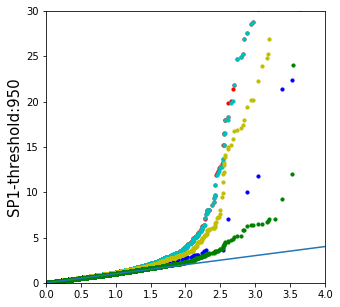

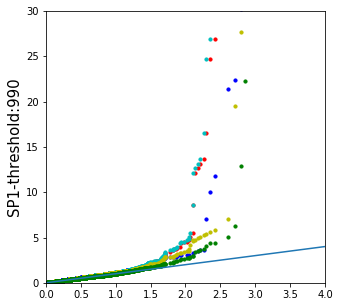

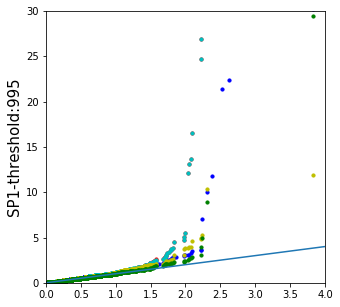

In [9]:
import random
from math import log10

for f in factors:
    if f != "SP1":
        continue
    for perc_index in range(len(rank_perc)):
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]
        core = gwd[f][gwd[f]["core"] == 1]
        noncore = high_scored_ab[high_scored_ab["core"] == 0]
        print (high_scored_ab.shape[0], core.shape[0], noncore.shape[0])
        # control - same MA_FREA distribution
        dist, _ = numpy.histogram(high_scored_ab["MA_FREQ"].tolist(), bins=bins)
        control_list = []
        control_list_all = []
        for bin_index in range(len(bins)-1):
            lower, upper = bins[bin_index], bins[bin_index + 1]
            n_samples = dist[bin_index]
            control_list.append((gwd[f][(gwd[f]["MA_FREQ"] >= lower) & (gwd[f]["MA_FREQ"] < upper)]).sample(n_samples))
            control_list_all.append((gwas[(gwas["MA_FREQ"] >= lower) & (gwas["MA_FREQ"] < upper)]).sample(n_samples))
        control = pd.concat(control_list)
        control_all = pd.concat(control_list_all)
                
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        s_core = core["MLOG10P"]
        s_noncore = noncore["MLOG10P"]
        s_ct = control["MLOG10P"]
        s_ct_all = control_all["MLOG10P"]

        
        s_random = [-log10(random.random()) for _ in range(max(high_scored_ab.shape[0], core.shape[0]))]
        s_random_ab = s_random[:high_scored_ab.shape[0]]
        s_random_core = s_random[:core.shape[0]]
        s_random_noncore = s_random[:noncore.shape[0]]
        
        y_points_ab = sorted(s_high_scored_ab.values.tolist())
        y_points_core = sorted(s_core.values.tolist())
        y_points_ct = sorted(s_ct.values.tolist())
        y_points_noncore = sorted(s_noncore.values.tolist())
        y_points_ct_all = sorted(s_ct_all.values.tolist())
        x_points_ab = sorted(s_random_ab)
        x_points_core = sorted(s_random_core)
        x_points_noncore = sorted(s_random_noncore)
        
        fig = plt.figure()
        fig.set_size_inches((5, 5))
        ax = fig.add_subplot(111)
        ax.scatter(x_points_ab, y_points_ab, c="r", s=10)
        ax.scatter(x_points_core, y_points_core, c="b", s=10)
        ax.scatter(x_points_noncore, y_points_noncore, c="c", s=10)
        ax.scatter(x_points_ab, y_points_ct, c="y", s=10)
        ax.scatter(x_points_ab, y_points_ct_all, c="g", s=10)
        ax.set_ylabel("%s-threshold:%d" %(f, rank_perc[perc_index]), size=15)
        ((xmin,xmax), (ymin,ymax)) = ((0, 4), (0, 30))
        ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

In [13]:
results = gwd["SP1"][gwd["SP1"]["rank"] >= rank_perc[0]]
results = results.sort_values("MLOG10P", ascending=False)
with open("/storage/pandaman/project/GWAS/high_scored.csv", 'w') as ofile:
    ofile.write(results.to_csv(index=False))

In [14]:
results

,chrom,start,raw.score,snr.score,rank,core,factor,VARIANT,ID_dbSNP49,REF,ALT,ALT_MINOR,DIRECTION,EFFECT,SE,P,MLOG10P,ALT_FREQ,MA_FREQ
202175,chr17,38137032,0.000160,7.962043,988.0,0,SP1,17:38137033_A_G,rs3859189,A,G,True,-,-0.094825,0.003603,1.180000e-152,151.929500,0.4534,0.4534
67348,chr6,31705863,0.000273,9.036834,973.0,0,SP1,6:31705864_C_T,rs3101018,C,T,True,-,-0.107821,0.005278,9.350000e-93,92.029350,0.1322,0.1322
113741,chr6,31276199,0.000278,3.971249,951.0,0,SP1,6:31276200_C_T,rs1634758,C,T,True,+,0.092371,0.004986,1.232000e-76,75.909310,0.1535,0.1535
113717,chr6,31276041,0.000437,6.242410,990.0,0,SP1,6:31276042_C_A,rs1616538,C,A,True,+,0.092332,0.004991,2.049000e-76,75.688520,0.1531,0.1531
39419,chr17,37912376,0.000249,9.412739,981.0,0,SP1,17:37912377_C_T,rs12946510,C,T,True,-,-0.063934,0.003590,5.818000e-71,70.235230,0.4752,0.4752
113575,chr6,30650025,0.000184,8.402001,976.0,0,SP1,6:30650026_G_A,rs9262142,G,A,True,-,-0.086086,0.005062,7.433000e-65,64.128820,0.1462,0.1462
113520,chr6,30081245,0.000953,28.002777,997.0,0,SP1,6:30081246_C_T,rs2523986,C,T,True,-,-0.076250,0.004841,6.749000e-56,55.170730,0.1627,0.1627
245407,chr6,32430728,0.000178,5.596626,964.0,0,SP1,6:32430729_C_T,rs7766843,C,T,True,-,-0.063556,0.004134,2.486000e-53,52.604560,0.2477,0.2477
224675,chr6,28304383,0.000610,19.585510,995.0,0,SP1,6:28304384_A_C,rs67340775,A,C,True,-,-0.080283,0.005572,4.659000e-47,46.331720,0.1168,0.1168
270391,chr10,99078744,0.000978,4.347233,958.0,0,SP1,10:99078745_C_T,rs3740512,C,T,False,+,0.049519,0.003652,6.850000e-42,41.164290,0.5973,0.4027


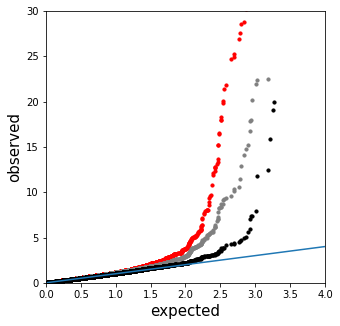

In [44]:
for f in factors:
    if f != "SP1":
        continue
    for perc_index in [0]:
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]

        # control - same MA_FREA distribution
        dist, _ = numpy.histogram(high_scored_ab["MA_FREQ"].tolist(), bins=bins)
        control_list = []
        control_list_all = []
        for bin_index in range(len(bins)-1):
            lower, upper = bins[bin_index], bins[bin_index + 1]
            n_samples = dist[bin_index]
            control_list.append((gwd[f][(gwd[f]["MA_FREQ"] >= lower) & (gwd[f]["MA_FREQ"] < upper)]).sample(n_samples))
            control_list_all.append((gwas[(gwas["MA_FREQ"] >= lower) & (gwas["MA_FREQ"] < upper)]).sample(n_samples))
        control = pd.concat(control_list)
        control_all = pd.concat(control_list_all)
        
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        s_ct = control["MLOG10P"]
        s_ct_all = control_all["MLOG10P"]

        s_random = [-log10(random.random()) for _ in range(high_scored_ab.shape[0])]
        
        y_points_ab = sorted(s_high_scored_ab.values.tolist())
        y_points_ct = sorted(s_ct.values.tolist())
        y_points_ct_all = sorted(s_ct_all.values.tolist())
        x_points = sorted(s_random)
        
        fig = plt.figure()
        fig.set_size_inches((5, 5))
        ax = fig.add_subplot(111)
        ax.scatter(x_points, y_points_ab, c="r", s=10)
        ax.scatter(x_points, y_points_ct, c="grey", s=10)
        ax.scatter(x_points, y_points_ct_all, c="k", s=10)
        ax.set_xlabel("expected", size=15)
        ax.set_ylabel("observed", size=15)
        ((xmin,xmax), (ymin,ymax)) = ((0, 4), (0, 30))
        ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

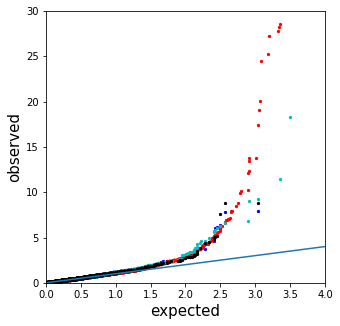

In [41]:
factors_to_plot = ["IRF4", "PU1", "ZEB1", "Znf143"]
f2c = {"IRF4":"b", "PU1":'r', "ZEB1":"c", "Znf143":"k"}

for perc_index in [0]:
    fig = plt.figure()
    fig.set_size_inches((5, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel("expected", size=15)
    ax.set_ylabel("observed", size=15)
    ((xmin,xmax), (ymin,ymax)) = ((0, 4), (0, 30))
    ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    s_random = [-log10(random.random()) for _ in range(int(10e6))]
    for f in factors_to_plot:
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        y_points_ab = sorted(s_high_scored_ab.values.tolist())        
        x_points = sorted(s_random[:high_scored_ab.shape[0]])
        
        ax.scatter(x_points, y_points_ab, c=f2c[f], s=5)